In [17]:
import sys
import pandas as pd
import numpy as np
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
from csgo.parser import DemoParser
from csgo.parser import FrameParser
pd.options.display.max_columns = None
# Create parser object
# Set log=True above if you want to produce a logfile for the parser
demo_parser = DemoParser(demofile = "DemoManager/SKADE/Inferno/18-04-2021&Young Ninjas.dem", match_id = "big-vs-g2-dust")
frame_parser = FrameParser(demofile = "DemoManager/SKADE/Inferno/18-04-2021&Young Ninjas.dem", match_id = "big-vs-g2-dust")

# # Parse the demofile, output results to dictionary with df name as key
demo_data = demo_parser.parse()
frame_data = frame_parser.parse(df=True)


TypeError: __init__() got an unexpected keyword argument 'parse_rate'

In [58]:
version("pandas")

NameError: name 'version' is not defined

     Round Round Round Round Round Round Round Round Round Round Round Round  \
0       \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n   
1       \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n   
2       \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n   
3       \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n   
4       \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
1019  None  None  None  None  None  None  None  None  None  None  None  None   
1020  None  None  None  None  None  None  None  None  None  None  None  None   
1021  None  None  None  None  None  None  None  None  None  None  None  None   
1022  None  None  None  None  None  None  None  None  None  None  None  None   
1023  None  None  None  None  None  None  None  None  None  None  None  None   

     Round Round Round Round Round Roun

In [3]:
teams = pd.unique(demo_data["Rounds"]["RoundWinner"])

In [4]:
rounds_t = demo_data["Rounds"][demo_data["Rounds"]["RoundWinnerSide"] == "T"].groupby("RoundWinner").size().reset_index(name="RoundsT")
if len(rounds_t) < 2:
    res_t = next((i for i, x in enumerate(teams) if not x == rounds_t["RoundWinner"][0]), None)
    rounds_t = rounds_t.append(pd.DataFrame({"RoundWinner": [teams[res_t]], "RoundsT" : [0]}),ignore_index=True)
rounds_ct = demo_data["Rounds"][demo_data["Rounds"]["RoundWinnerSide"] == "CT"].groupby("RoundWinner").size().reset_index(name="RoundsCT")
if len(rounds_ct) < 2:
    res_t = next((i for i, x in enumerate(teams) if not x == rounds_ct["RoundWinner"][0]), None)
    rounds_ct = rounds_ct.append(pd.DataFrame({"RoundWinner": [teams[res_t]], "RoundsCT" : [0]}),ignore_index=True)

rounds = rounds_t.merge(rounds_ct,left_on='RoundWinner', right_on='RoundWinner')
rounds

,RoundWinner,RoundsT,RoundsCT
0,SKADE,6,10
1,Young Ninjas,5,1


In [5]:
def getPlayerInfo (data):
    kill_data = data["Kills"]
    kills =  kill_data.groupby(["AttackerName"]).size().reset_index(name="Kills")
    deaths =  kill_data.groupby(["VictimName"]).size().reset_index(name="Deaths")
    total_rounds = data["Rounds"].shape[0]
    kills["Entries"] = np.zeros(kills.shape[0],dtype=int)
    for ind,kill in enumerate(kill_data["RoundNum"], start=0):
        if (ind == 0) :
            kills.loc[kills["AttackerName"] == kill_data["AttackerName"][ind], "Entries"] += 1
            continue
        if (kill_data["RoundNum"][ind - 1] != kill_data["RoundNum"][ind]):
            kills.loc[kills["AttackerName"] == kill_data["AttackerName"][ind], "Entries"] += 1
            continue
        kills= kills[kills["AttackerName"] != "NA"] 
    # Add Armor damage to the HP damage for each damage entry to get total damage
    data["Damages"]["HpDamageArmor"] = data["Damages"]["HpDamage"] + data["Damages"]["ArmorDamage"]
    data["Damages"]["KillHpDamageArmor"] = data["Damages"]["KillHpDamage"] + data["Damages"]["ArmorDamage"]
    #Perctange headshots 
    head_per = data["Kills"].groupby("AttackerName").IsHeadshot.mean().reset_index(name="HeadShotPct")
    # Calculate
    adr = (data["Damages"].groupby(["AttackerName"])["HpDamageArmor", "KillHpDamageArmor"].sum()/total_rounds).reset_index()
    adr.columns = ["PlayerName", "RawADR", "NormADR"]
    adr = adr[adr["PlayerName"] != "NA"]
    final_data = kills.merge(deaths, left_on="AttackerName", right_on="VictimName").merge(adr, left_on="VictimName", right_on ="PlayerName")
    final_data = final_data.merge(head_per,left_on="AttackerName", right_on="AttackerName" )
    final_data = final_data[["PlayerName", "Kills", "Deaths", "NormADR","HeadShotPct", "Entries"]]
    return final_data
getPlayerInfo(demo_data)
# smoke_thrown = data["Grenades"][data["Grenades"]["GrenadeType"].isin(["Smoke"])].groupby("PlayerName").size().reset_index(name="SmokeThrown")
# # You can also write the demofile data to JSON using
# smoke_thrown
# demo_data["Kills"]
# list(filter(lambda x: x > 1, demo_data["Kills"]["RoundNum"]))


<ipython-input-5-234c69300b2b>:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  adr = (data["Damages"].groupby(["AttackerName"])["HpDamageArmor", "KillHpDamageArmor"].sum()/total_rounds).reset_index()


,PlayerName,Kills,Deaths,NormADR,HeadShotPct,Entries
0,Duplicate,24,8,135.136364,0.375000,3
1,LNZ,10,17,81.727273,0.700000,2
2,Mann3n,9,19,66.681818,0.666667,1
3,Rainwaker,18,9,111.000000,0.222222,1
4,SHiPZ1017,12,13,90.590909,0.416667,0
5,Sapec,11,19,77.818182,0.454545,6
6,dennyslaw,28,9,145.500000,0.500000,4
7,nilo,8,17,69.681818,0.750000,1
8,oxygen1735,9,13,59.363636,0.444444,1
9,phzy,13,18,84.636364,0.307692,3


In [8]:
# Считаем количество поставленных бомб на разные планты 
plant_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="PlantOnA")
plant_b = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "B"].groupby("Team").size().reset_index(name="PlantOnB")
# Если на а или б ни разу не поставили бомбу
if plant_a.empty or plant_b.empty:
    plants_a = pd.DataFrame({'Team': teams, 'PlantOnA': [0,0]}) if plant_a.empty else plants_a
    plants_b =  pd.DataFrame({'Team': teams, 'PlantOnB': [0,0]})if plant_b.empty else plants_b
# Если какая-либо из команд не поставила ни разу бомбу на плант а или б
if len(plant_a) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == plant_a["Team"][0]), None)
    plants_a = plants_a.append(pd.DataFrame({"Team": [teams[res_t]], "PlantOnA" : [0]}),ignore_index=True)
if len(plant_b) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == plant_b["Team"][0]), None)
    plants_b = plants_b.append(pd.DataFrame({"Team": [teams[res_t]], "PlantOnB" : [0]}),ignore_index=True)
plants = plant_a.merge(plant_b, left_on="Team", right_on="Team")

defuses_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Defuse"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="DefuseOnA")
defuses_b = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Defuse"][demo_data["BombEvents"]["BombSite"] == "B"].groupby("Team").size().reset_index(name="DefuseOnB")
if defuses_a.empty or defuses_b.empty:
    defuses_a = pd.DataFrame({'Team': teams, 'DefuseOnA': [0,0]}) if defuses_a.empty else defuses_a
    defuses_b = pd.DataFrame({'Team': teams, 'DefuseOnB': [0,0]}) if defuses_b.empty else defuses_b
# Если какая-либо из команд не задифьюзела ни разу бомбу на а или б
if len(defuses_a) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == defuses_a["Team"][0]), None)
    defuses_a = defuses_a.append(pd.DataFrame({"Team": [teams[res_t]], "DefuseOnA" : [0]}),ignore_index=True)
if len(defuses_b) < 2 :
    res_t = next((i for i, x in enumerate(teams) if not x == defuses_b["Team"][0]), None)
    defuses_b = defuses_b.append(pd.DataFrame({"Team": [teams[res_t]], "DefuseOnB" : [0]}),ignore_index=True)
plants = plant_a.merge(plant_b, left_on="Team", right_on="Team")
defuses = defuses_a.merge(defuses_b, left_on="Team", right_on="Team")


rounds_bombs = plants.merge(defuses, left_on="Team", right_on="Team")
rounds_bombs["SucPercA"] = (rounds_bombs["PlantOnA"] - rounds_bombs["DefuseOnA"].iloc[::-1].values) / rounds_bombs["PlantOnA"]
rounds_bombs["SucPercB"] = (rounds_bombs["PlantOnB"] - rounds_bombs["DefuseOnB"].iloc[::-1].values) / rounds_bombs["PlantOnB"]
rounds_bombs
clear = demo_data["Rounds"][demo_data["Rounds"]["Reason"].isin(["CTWin", "TargetSaved"])].groupby("RoundWinner").size().reset_index(name="ClearRoundsCT")
if clear.empty:
    clear = pd.DataFrame({'Team': teams, 'ClearRoundsCT': [0,0]})
else:
    if len(clear["RoundWinner"]) < 2:
        res_t = next((i for i, x in enumerate(teams) if not x == clear["RoundWinner"][0]), None)
        clear = clear.append(pd.DataFrame({"RoundWinner": [teams[res_t]], "ClearRoundsCT" : [0]}),ignore_index=True)
clear.columns = ["Team","ClearRoundsCT"]
rounds_bombs = rounds_bombs.merge(clear, left_on="Team", right_on="Team")
rounds_bombs





<ipython-input-8-1e219f6828a4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plant_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="PlantOnA")
<ipython-input-8-1e219f6828a4>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plant_b = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Plant"][demo_data["BombEvents"]["BombSite"] == "B"].groupby("Team").size().reset_index(name="PlantOnB")
<ipython-input-8-1e219f6828a4>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  defuses_a = demo_data["BombEvents"][demo_data["BombEvents"]["EventType"] == "Defuse"][demo_data["BombEvents"]["BombSite"] == "A"].groupby("Team").size().reset_index(name="DefuseOnA")
<ipython-input-8-1e219f6828a4>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  defuses_b

,Team,PlantOnA,PlantOnB,DefuseOnA,DefuseOnB,SucPercA,SucPercB,ClearRoundsCT
0,SKADE,2,3,0,1,0.5,1.0,9
1,Young Ninjas,4,2,1,0,1.0,0.5,0


In [9]:
nade_dmg = demo_data["Damages"][demo_data["Damages"]["Weapon"].isin(["Incendiary", "Molotov", "HE"])]
smoke_thrown = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Smoke"])].groupby("Team").size().reset_index(name="Smoke")
flash_thrown_ct = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Flash"])][demo_data["Grenades"]["Side"] == "CT"].groupby("Team").size().reset_index(name="FlashCT")
flash_thrown_t = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Flash"])][demo_data["Grenades"]["Side"] == "T"].groupby("Team").size().reset_index(name="FlashT")
#smoke_thrown.div(2)
smoke_thrown["Smoke"] = round(smoke_thrown["Smoke"] / 2)
grenades = smoke_thrown.join(flash_thrown_ct, lsuffix='', rsuffix='_other')
grenades = grenades.merge(flash_thrown_t,left_on='Team', right_on="Team")
flashes_avg_ct = flash_thrown_ct["FlashCT"] / (rounds["RoundsCT"][0] + rounds["RoundsT"][1])
flashes_avg_t = flash_thrown_t["FlashT"] / (rounds["RoundsCT"][1] + rounds["RoundsT"][0])
nade_dmg_df = nade_dmg.groupby("AttackerTeam").HpDamage.sum().reset_index(name="UtilityDamage").sort_values("UtilityDamage", ascending=False)
grenades = grenades.merge(nade_dmg_df, left_on='Team', right_on='AttackerTeam')
grenades["AvgFlashesCT"] = flashes_avg_ct
grenades["AvgFlashesT"] = flashes_avg_t
grenades = grenades [["Team", "Smoke", "FlashCT","AvgFlashesCT", "FlashT", "AvgFlashesT", "UtilityDamage"]]
grenades
datInfo = grenades.merge(rounds_bombs, left_on="Team", right_on="Team")
datInfo

<ipython-input-9-9fb8b3fa5828>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  flash_thrown_ct = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Flash"])][demo_data["Grenades"]["Side"] == "CT"].groupby("Team").size().reset_index(name="FlashCT")
<ipython-input-9-9fb8b3fa5828>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  flash_thrown_t = demo_data["Grenades"][demo_data["Grenades"]["GrenadeType"].isin(["Flash"])][demo_data["Grenades"]["Side"] == "T"].groupby("Team").size().reset_index(name="FlashT")


,Team,Smoke,FlashCT,AvgFlashesCT,FlashT,AvgFlashesT,UtilityDamage,PlantOnA,PlantOnB,DefuseOnA,DefuseOnB,SucPercA,SucPercB,ClearRoundsCT
0,SKADE,58.0,17,1.133333,17,2.428571,1491,2,3,0,1,0.5,1.0,9
1,Young Ninjas,44.0,12,0.800000,52,7.428571,470,4,2,1,0,1.0,0.5,0


In [14]:
demo_data["Damages"][demo_data["Damages"]["Weapon"] == "Flash"]

,MatchId,MapName,RoundNum,Tick,Second,VictimX,VictimY,VictimZ,VictimXViz,VictimYViz,VictimViewX,VictimViewY,VictimAreaId,VictimAreaName,AttackerX,AttackerY,AttackerZ,AttackerXViz,AttackerYViz,AttackerViewX,AttackerViewY,AttackerAreaId,AttackerAreaName,VictimSteamId,VictimName,VictimTeam,VictimSide,VictimTeamEqVal,AttackerSteamId,AttackerName,AttackerTeam,AttackerSide,AttackerTeamEqVal,HpDamage,KillHpDamage,ArmorDamage,Weapon,HitGroup,HpDamageArmor,KillHpDamageArmor


In [15]:
rounds

,RoundWinner,RoundsT,RoundsCT
0,SKADE,6,10
1,Young Ninjas,5,1


In [16]:
df = demo_parser.parse(df = True)

TypeError: parse() got an unexpected keyword argument 'df'

<ipython-input-5-234c69300b2b>:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  adr = (data["Damages"].groupby(["AttackerName"])["HpDamageArmor", "KillHpDamageArmor"].sum()/total_rounds).reset_index()


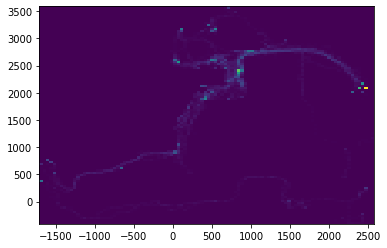

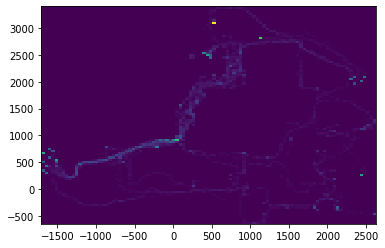

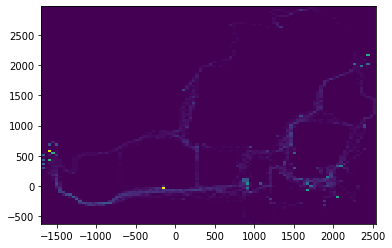

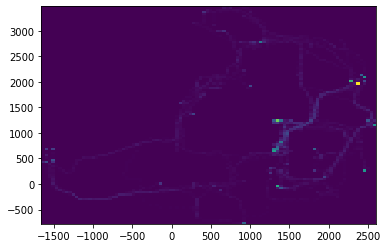

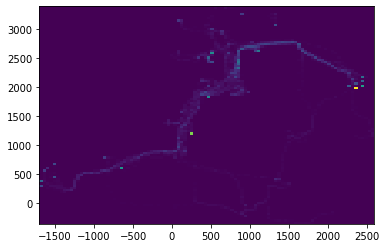

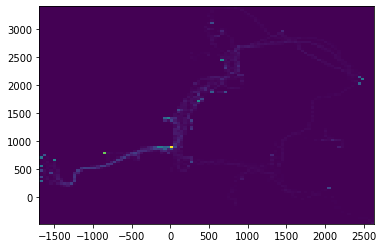

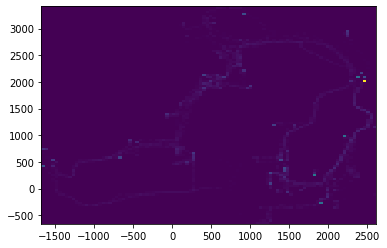

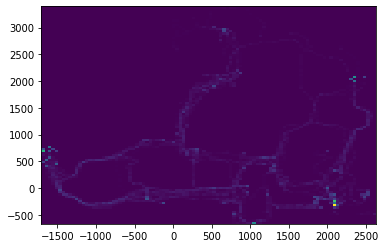

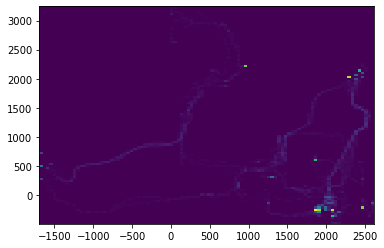

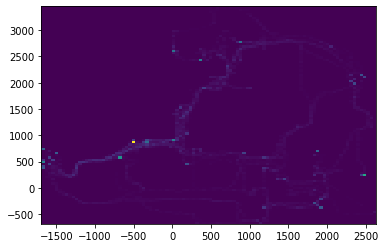

In [31]:
import matplotlib.pyplot as plt
for player in getPlayerInfo(demo_data)["PlayerName"]:
    ticks = frame_data.sort_values(by=['Tick'])
    ticks = ticks [ticks["Hp"] > 0]
    ticks = ticks[ticks["TicksSinceStart"] != '0']
    playersPos = ticks[['PlayerName','X', 'Y']].groupby('PlayerName').agg(list)
    plt.hist2d(playersPos["X"][player],playersPos["Y"][player],bins=100)

    plt.show()


In [26]:
def get_quantile(x, y, x_max, y_max):
        arr = list(zip(x, y))
        for i in range(0, len(arr)):
                arr[i] = (int(arr[i][0]), int(arr[i][1]))
        return len(set(arr))/(x_max*y_max)
for player in getPlayerInfo(demo_data)["PlayerName"]:    
    print(get_quantile(playersPos['X'][player], playersPos['Y'][player], 3000, 3500) * 1000)

0.8193333333333334
0.6995238095238095
0.7380952380952381
0.7604761904761904
0.6773333333333332
0.606095238095238
0.7599047619047619
0.8407619047619048
0.6821904761904762
0.7649523809523809


<ipython-input-5-234c69300b2b>:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  adr = (data["Damages"].groupby(["AttackerName"])["HpDamageArmor", "KillHpDamageArmor"].sum()/total_rounds).reset_index()


In [20]:
def count_streak():
    round_streaks = {teams[0]: [], teams[1] : []}
    winner_round = ''
    count = 0
    for ind, win in enumerate(demo_data["Rounds"]["RoundWinner"]):
        if (ind == 0):
            winner_round = demo_data["Rounds"]["RoundWinner"][0]
            count +=1 
        else:
            if (winner_round != demo_data["Rounds"]["RoundWinner"][ind]):
                round_streaks[winner_round].append(count)
                count = 1
                winner_round = demo_data["Rounds"]["RoundWinner"][ind]
            else: 
                count+=1
    return round_streaks

count_streak()

{'Young Ninjas': [1, 1, 2, 1, 1], 'SKADE': [5, 1, 1, 3]}

In [32]:
print(len(playersPos['Y']['Rainwaker']))

10330


In [16]:
 ticks = frame_data.sort_values(by=['Tick'])
print(len(list(ticks['Tick'].values)))

117930


In [47]:
frame_data.columns

Index(['SteamId', 'RoundNum', 'Tick', 'Side', 'TeamName', 'EqVal',
       'PlayerName', 'Hp', 'Armor', 'HasDefuse', 'HasHelmet', 'X', 'Y', 'Z',
       'XViz', 'YViz', 'AreaName', 'AreaId', 'TicksSinceStart', 'MatchId',
       'MapName', 'Seconds'],
      dtype='object')